In [1]:
import os
import collections
from pathlib import Path

import numpy as np

from astropy import table
from astropy import visualization
import specutils

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
os.environ.setdefault('CRDS_PATH', 'crds_cache')
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'  # overrides in case you are set up for HST

In [3]:
from jwst import datamodels
from jwst.pipeline import Spec2Pipeline

Use the download list generated from [M31_spec_download.ipynb](file://M31_spec_download.ipynb)

In [4]:
ls download*ecsv

downloaded_assoc_products_2023-02-03_18:35:13.698.ecsv
downloaded_fgs_products_2023-02-01_18:02:26.650.ecsv
downloaded_products_2023-02-01_17:43:29.304.ecsv
downloaded_products_2023-02-03_18:08:08.193.ecsv


In [5]:
downloaded_tab = table.Table.read('downloaded_products_2023-02-01_17:43:29.304.ecsv')
downloaded_paths = [Path(pathstr) for pathstr in np.unique(downloaded_tab['Local Path'])]
print('unique', len(downloaded_paths))
downloaded_tab

unique 472


Local Path,Status,Message,URL
str110,str8,object,object
./mastDownload/JWST/jw02609-o009_s00001_nirspec_f100lp-g140h/jw02609-o009_s00001_nirspec_f100lp-g140h_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609-o009_s00001_nirspec_f100lp-g140h/jw02609-o009_s00001_nirspec_f100lp-g140h_crf.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609-o009_s00001_nirspec_f100lp-g140h/jw02609-o009_s00001_nirspec_f100lp-g140h_s2d.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609-o009_s00001_nirspec_f100lp-g140h/jw02609-o009_s00001_nirspec_f100lp-g140h_x1d.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609-o009_s00002_nirspec_f100lp-g140h/jw02609-o009_s00002_nirspec_f100lp-g140h_cal.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609-o009_s00002_nirspec_f100lp-g140h/jw02609-o009_s00002_nirspec_f100lp-g140h_crf.fits,COMPLETE,None,None
...,...,...,...
./mastDownload/JWST/jw02609009001_0410b_00001_nrs2/jw02609009001_0410b_00001_nrs2_x1d.fits,COMPLETE,None,None
./mastDownload/JWST/jw02609009001_0410b_00001_nrs2/jw02609009001_0410b_00001_nrs2_x1d.fits,COMPLETE,None,None


In [6]:
paths_by_filetype = collections.defaultdict(lambda:list())
for p in downloaded_paths:
    filetype = p.stem.split('_')[-1]
    paths_by_filetype[filetype].append(p)
paths_by_filetype = dict(paths_by_filetype)
{k:len(v) for k,v in paths_by_filetype.items()}

{'cal': 121, 'crf': 103, 's2d': 115, 'x1d': 115, 'rate': 18}

In [7]:
rate_dms = [datamodels.open(p) for p in paths_by_filetype['rate']]

rate_dms[0].info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.13.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): a0c702f851925a8084908abe992d6c4b3da5b134d4f587dcbaafc61bac036df5
├─data (ndarray): shape=(2048, 2048), dtype=float32
├─dq (ndarray): shape=(2048, 2048), dtype=uint32
├─err (ndarray): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.8.2
│ ├─compress (bool): False
│ └─29 not shown
├─var_poisson (ndarray): shape=(2048, 2048), dtype=float32
└─var_rnoise (ndarray): shape=(2048, 2048), dtype=float32
Some nodes not shown.


In [8]:
align_dms = [dm for dm in rate_dms if dm.meta.instrument.filter.endswith('W')]

spec_dms = [dm for dm in rate_dms if dm.meta.instrument.filter.endswith('LP')]
spec_paths = [[p for p in paths_by_filetype['rate'] if p.name == dm.meta.filename][0] for dm in spec_dms]
spec_asns = [[f for f in p.parent.iterdir() if f.stem.endswith('asn')] for p in spec_paths]
spec_msas = [[f for f in p.parent.iterdir() if f.stem.endswith('msa')] for p in spec_paths]

len(align_dms), len(spec_dms)

(6, 12)

In [9]:
spec_asns[0][0]

PosixPath('mastDownload/JWST/jw02609009001_04101_00001_nrs1/jw02609-o009_20230124t220031_spec2_00008_asn.json')

In [9]:
!mkdir -p widened_2

In [10]:
def run_spec2(asn):
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.output_dir = 'widened_2'

    spec2.srctype.source_type = 'POINT'
    spec2.flat_field.save_interpolated_flat = True

    spec2.bkg_subtract.skip = False
    spec2.resample_spec.skip = True
    spec2.extract_1d.skip = True

    spec2.assign_wcs.slit_y_high *= 2
    spec2.assign_wcs.slit_y_low *= 2

    return spec2(asn)

In [31]:
res0 = run_spec2(spec_asns[0][0])

2023-02-08 17:05:43,339 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-08 17:05:43,340 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-08 17:05:43,342 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-08 17:05:43,343 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-08 17:05:43,343 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-08 17:05:43,344 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-08 17:05:43,347 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-08 17:05:43,348 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-08 17:05:43,349 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-08 17:05:43,350 - stpipe.Spec2Pipeline.

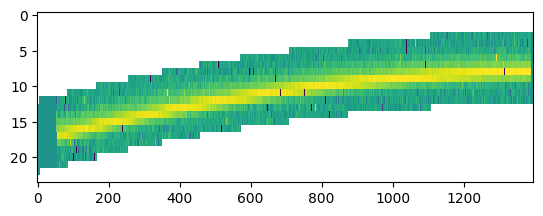

In [33]:
visualization.imshow_norm(res0[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [52]:
res1 = run_spec2(spec_asns[1][0])

2023-02-08 21:18:00,506 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-08 21:18:00,507 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-08 21:18:00,508 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-08 21:18:00,509 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-08 21:18:00,510 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-08 21:18:00,511 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-08 21:18:00,514 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-08 21:18:00,516 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-08 21:18:00,517 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-08 21:18:00,517 - stpipe.Spec2Pipeline.

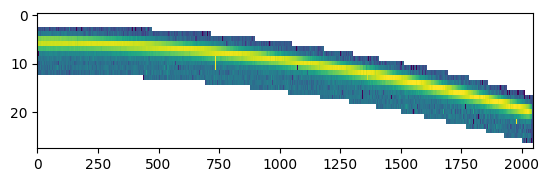

In [53]:
visualization.imshow_norm(res1[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [54]:
res2 = run_spec2(spec_asns[2][0])

2023-02-08 21:31:54,574 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-08 21:31:54,576 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-08 21:31:54,578 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-08 21:31:54,579 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-08 21:31:54,580 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-08 21:31:54,581 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-08 21:31:54,584 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-08 21:31:54,585 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-08 21:31:54,586 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-08 21:31:54,587 - stpipe.Spec2Pipeline.

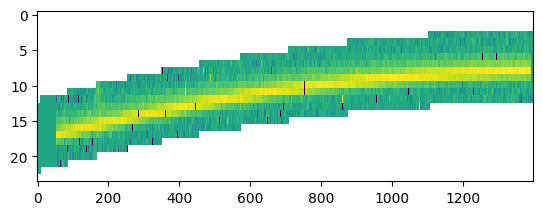

In [55]:
visualization.imshow_norm(res2[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [56]:
res3 = run_spec2(spec_asns[3][0])

2023-02-08 21:41:35,947 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-08 21:41:35,948 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-08 21:41:35,950 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-08 21:41:35,950 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-08 21:41:35,951 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-08 21:41:35,952 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-08 21:41:35,954 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-08 21:41:35,955 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-08 21:41:35,956 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-08 21:41:35,957 - stpipe.Spec2Pipeline.

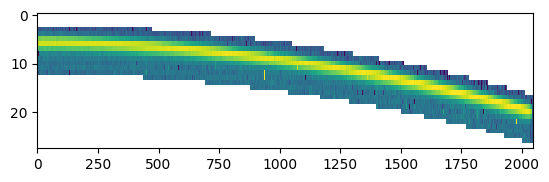

In [57]:
visualization.imshow_norm(res3[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [58]:
res4 = run_spec2(spec_asns[4][0])

2023-02-08 21:58:42,966 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-08 21:58:42,967 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-08 21:58:42,968 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-08 21:58:42,969 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-08 21:58:42,970 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-08 21:58:42,971 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-08 21:58:42,974 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-08 21:58:42,975 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-08 21:58:42,975 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-08 21:58:42,976 - stpipe.Spec2Pipeline.

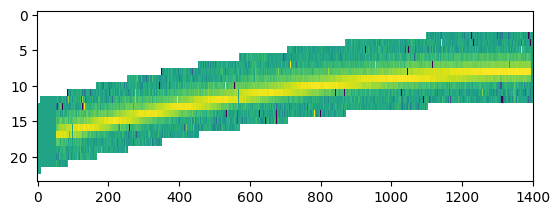

In [59]:
visualization.imshow_norm(res4[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [11]:
res5 = run_spec2(spec_asns[5][0])

2023-02-09 16:49:10,790 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 16:49:10,791 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 16:49:10,792 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 16:49:10,793 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 16:49:10,793 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 16:49:10,794 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 16:49:10,796 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 16:49:10,796 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 16:49:10,797 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 16:49:10,798 - stpipe.Spec2Pipeline.

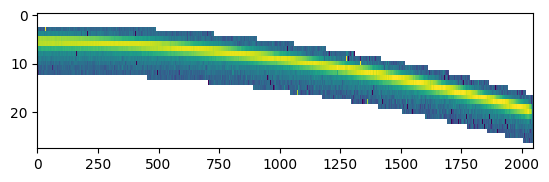

In [12]:
visualization.imshow_norm(res5[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [13]:
res6 = run_spec2(spec_asns[6][0])

2023-02-09 17:00:12,076 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:00:12,077 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:00:12,079 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:00:12,079 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:00:12,080 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:00:12,081 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:00:12,084 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:00:12,086 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:00:12,087 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:00:12,088 - stpipe.Spec2Pipeline.

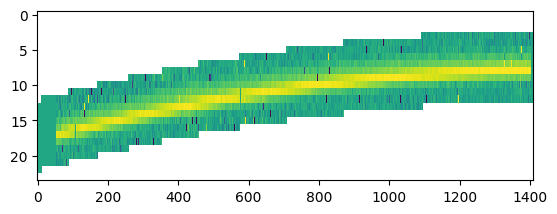

In [14]:
visualization.imshow_norm(res6[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [15]:
res7 = run_spec2(spec_asns[7][0])

2023-02-09 17:07:00,001 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:07:00,003 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:07:00,004 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:07:00,005 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:07:00,006 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:07:00,007 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:07:00,009 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:07:00,010 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:07:00,011 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:07:00,011 - stpipe.Spec2Pipeline.

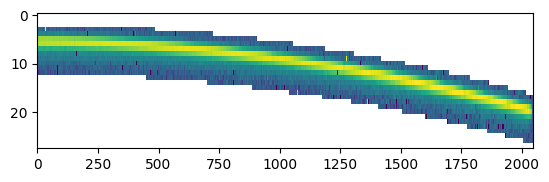

In [16]:
visualization.imshow_norm(res7[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [17]:
res8 = run_spec2(spec_asns[8][0])

2023-02-09 17:18:36,862 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:18:36,863 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:18:36,865 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:18:36,865 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:18:36,866 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:18:36,867 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:18:36,870 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:18:36,871 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:18:36,872 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:18:36,872 - stpipe.Spec2Pipeline.

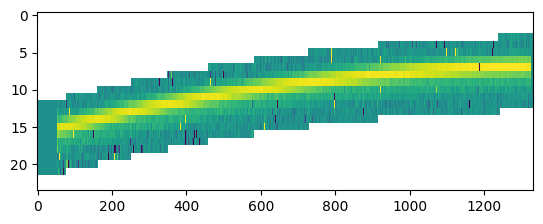

In [18]:
visualization.imshow_norm(res8[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [19]:
res9 = run_spec2(spec_asns[9][0])

2023-02-09 17:25:51,095 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:25:51,096 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:25:51,097 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:25:51,098 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:25:51,099 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:25:51,100 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:25:51,103 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:25:51,105 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:25:51,106 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:25:51,107 - stpipe.Spec2Pipeline.

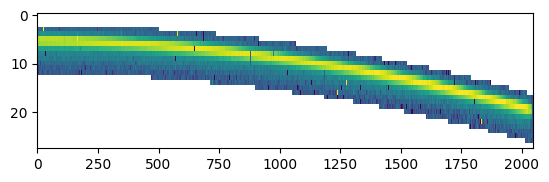

In [20]:
visualization.imshow_norm(res9[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [21]:
res10 = run_spec2(spec_asns[10][0])

2023-02-09 17:38:52,181 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:38:52,183 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:38:52,184 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:38:52,185 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:38:52,186 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:38:52,187 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:38:52,190 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:38:52,191 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:38:52,192 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:38:52,193 - stpipe.Spec2Pipeline.

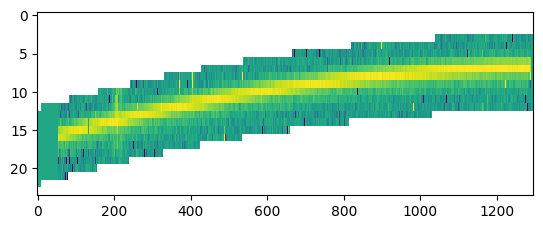

In [22]:
visualization.imshow_norm(res10[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [23]:
res11 = run_spec2(spec_asns[11][0])

2023-02-09 17:46:23,812 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-02-09 17:46:23,814 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-02-09 17:46:23,815 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-02-09 17:46:23,816 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-02-09 17:46:23,816 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-02-09 17:46:23,817 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-02-09 17:46:23,820 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-02-09 17:46:23,821 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-02-09 17:46:23,821 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-02-09 17:46:23,822 - stpipe.Spec2Pipeline.

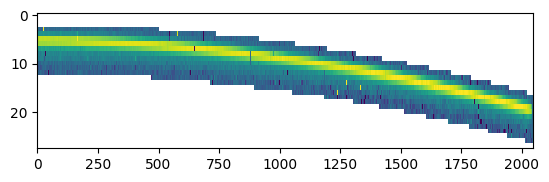

In [24]:
visualization.imshow_norm(res11[0].slits[50].data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         );

In [28]:
list(res11[0].meta.items())

[('model_type', 'MultiSlitModel'),
 ('date', '2023-02-09T18:47:36.385'),
 ('origin', 'STSCI'),
 ('time_sys', 'UTC'),
 ('time_unit', 's'),
 ('filename', 'jw02609009001_0410b_00001_nrs2_cal.fits'),
 ('data_processing_software_version', '2022_4a'),
 ('prd_software_version', 'PRDOPSSOC-059'),
 ('oss_software_version', '8.5'),
 ('calibration_software_version', '1.9.4'),
 ('calibration_software_revision', 'RELEASE'),
 ('telescope', 'JWST'),
 ('hga_move', False),
 ('pwfseet', 59919.7247765625),
 ('nwfsest', 0.0),
 ('compress', False),
 ('program.title',
  'Searching for the Alpha-Abundance Bimodality in the M31 Disk'),
 ('program.pi_name', 'Nidever, David'),
 ('program.category', 'GO'),
 ('program.science_category',
  'Stellar Populations and the Interstellar Medium'),
 ('observation.date', '2022-12-07'),
 ('observation.time', '07:49:49.077'),
 ('observation.date_beg', '2022-12-07T07:49:49.077'),
 ('observation.date_end', '2022-12-07T08:38:56.033'),
 ('observation.obs_id', 'V02609009001P00000